In [6]:
pip install face_recognition opencv-python pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install cmake

   ---------------------------------------- 0.0/36.7 MB ? eta -:--:--
    --------------------------------------- 0.8/36.7 MB 4.2 MB/s eta 0:00:09
   - -------------------------------------- 1.6/36.7 MB 4.0 MB/s eta 0:00:09
   -- ------------------------------------- 2.1/36.7 MB 3.4 MB/s eta 0:00:11
   --- ------------------------------------ 3.1/36.7 MB 3.8 MB/s eta 0:00:09
   ---- ----------------------------------- 4.2/36.7 MB 4.1 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/36.7 MB 4.1 MB/s eta 0:00:08
   ------ --------------------------------- 5.8/36.7 MB 4.2 MB/s eta 0:00:08
   ------- -------------------------------- 6.8/36.7 MB 4.1 MB/s eta 0:00:08
   -------- ------------------------------- 7.6/36.7 MB 4.0 MB/s eta 0:00:08
   --------- ------------------------------ 8.4/36.7 MB 4.0 MB/s eta 0:00:08
   --------- ------------------------------ 8.9/36.7 MB 3.9 MB/s eta 0:00:08
   ---------- ----------------------------- 9.7/36.7 MB 3.9 MB/s eta 0:00:07
   ---

In [1]:
!pip install dlib

  Using cached dlib-20.0.0.tar.gz (3.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for dlib: filename=dlib-20.0.0-cp312-cp312-win_amd64.whl size=2963144 sha256=6e0cfc609eb5587697a0b0cee2a2f97eb325c0967361f4bda1f04456451cb0b0
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\35\bc\f4\3551aa7a295bf59b6cbf9cb588197b668052e5ec92a02aff7f
Successfully built dlib


In [2]:
!pip install face_recognition

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0-py2.py3-none-any.whl
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)


In [11]:
import cv2
import numpy as np
import face_recognition
import os
from datetime import datetime
import pandas as pd
import time
import matplotlib.pyplot as plt

# === Liveness Detection: Haar cascades ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

# === Load known face encodings ===
path = 'faces'
images = []
student_info = []  # [(id, name), ...]

for filename in os.listdir(path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            images.append(img)
            base = os.path.splitext(filename)[0]  # e.g., 242024004_JiyaRoy
            if "_" in base:
                student_id, name = base.split("_", 1)
            else:
                student_id, name = "UnknownID", base
            student_info.append((student_id, name))

def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encodings = face_recognition.face_encodings(img)
        if encodings:
            encodeList.append(encodings[0])
    return encodeList

encodeListKnown = findEncodings(images)
print(f" Face encodings loaded for {len(encodeListKnown)} students.")

 Face encodings loaded for 14 students.


In [16]:
# === Excel Attendance Logger ===
def markAttendance(student_id, name):
    file_name = "attendance.xlsx"
    now = datetime.now()
    date_str = now.strftime('%Y-%m-%d')
    time_str = now.strftime('%H:%M:%S')

    # Load or create the Excel file
    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
        try:
            df = pd.read_excel(file_name, engine='openpyxl')
        except Exception as e:
            print(f" Error reading file: {e}, creating new one.")
            df = pd.DataFrame(columns=["Student ID", "Name", "Date", "Time"])
    else:
        df = pd.DataFrame(columns=["Student ID", "Name", "Date", "Time"])

    # Check if attendance already marked today for this person
    already_marked = (
        (df['Student ID'] == student_id) &
        (df['Date'] == date_str)
    ).any()

    if already_marked:
        print(f"  Attendance already marked for {name} ({student_id}) today.")
        return  # Skip adding again

    # Otherwise, mark new attendance
    new_entry = pd.DataFrame([[student_id, name, date_str, time_str]],
                             columns=["Student ID", "Name", "Date", "Time"])
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_excel(file_name, index=False, engine='openpyxl')
    print(f"  Attendance marked for {name} ({student_id}) at {time_str}")

# === Webcam Init ===
cap = cv2.VideoCapture(0)

# === Config ===
FACE_DISTANCE_THRESHOLD = 0.5
motion_detected_frames = 0
previous_locations = []

# === Analysis Variables ===
frame_count = 0
correct_recognitions = 0
false_accepts = 0
false_rejects = 0
unknown_count = 0
detection_times = []

marked_students = set()

# === Main Loop ===
while True:
    start_time = time.time()

    success, img = cap.read()
    if not success:
        break

    frame_count += 1
    img = cv2.flip(img, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Haar cascade for liveness (eyes blink detection)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    liveness_confirmed = False
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 1:
            liveness_confirmed = True
            break

    # === Face recognition ===
    imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)
    rgbS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

    facesCurFrame = face_recognition.face_locations(rgbS)
    encodesCurFrame = face_recognition.face_encodings(rgbS, facesCurFrame)

    recognized_in_frame = False

    for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
        if len(encodeListKnown) == 0:
            continue

        faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)
        if len(faceDis) == 0:
            continue

        matchIndex = np.argmin(faceDis)
        student_id, student_name = student_info[matchIndex]

        motion_detected = False
        if previous_locations:
            prev = previous_locations[-1]
            diff = np.linalg.norm(np.array(faceLoc) - np.array(prev))
            if diff > 3:
                motion_detected = True
        previous_locations.append(faceLoc)

        # === Recognition check ===
        if faceDis[matchIndex] < FACE_DISTANCE_THRESHOLD and (liveness_confirmed or motion_detected):
            name_display = student_name.upper()
            correct_recognitions += 1
            recognized_in_frame = True

            # ✅ Only mark attendance once per session
            if student_id not in marked_students:
                markAttendance(student_id, student_name)   # write to Excel
                marked_students.add(student_id)            # add to session set
            else:
                print(f" ⚠️ Attendance already marked for {student_name} ({student_id})")

        else:
            name_display = "Unknown"
            unknown_count += 1
            if liveness_confirmed:
                false_accepts += 1

        # === Draw bounding box & labels ===
        y1, x2, y2, x1 = [v * 4 for v in faceLoc]
        color = (0, 255, 0) if name_display != "Unknown" else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.rectangle(img, (x1, y2 - 35), (x2, y2), color, cv2.FILLED)
        cv2.putText(img, name_display, (x1 + 6, y2 - 6),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # === Show "Already Marked" on screen if already marked this session ===
        if student_id in marked_students:
            cv2.putText(img, "Already Marked", (x1 + 6, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    if not recognized_in_frame and liveness_confirmed:
        false_rejects += 1

    detection_times.append(time.time() - start_time)

    cv2.imshow('Smart Attendance', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

  Attendance marked for JiyaRoy (242024004) at 16:44:44
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)
 ⚠️ Attendance already marked for JiyaRoy (242024004)



=== 📊 PERFORMANCE SUMMARY ===
Total Frames Processed: 11
Correct Recognitions: 11
Unknown Detections: 0
False Accepts (FAR): 0.00%
False Rejects (FRR): 0.00%
Overall Accuracy: 100.00%
Average Detection Time per Frame: 0.508 sec


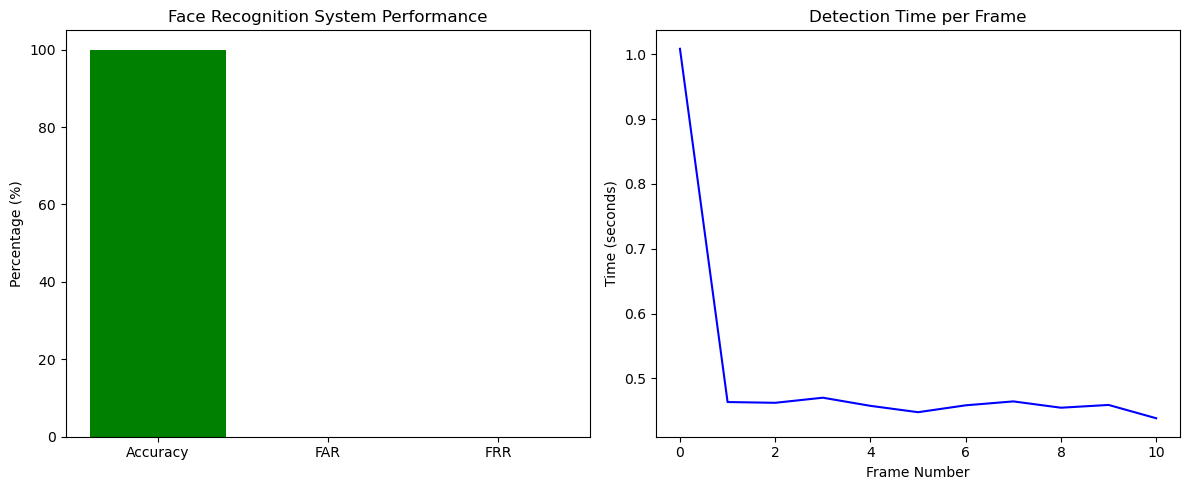

In [17]:
# === Performance Analysis ===
accuracy = (correct_recognitions / frame_count) * 100 if frame_count else 0
far = (false_accepts / frame_count) * 100
frr = (false_rejects / frame_count) * 100
avg_time = np.mean(detection_times)

print("\n=== 📊 PERFORMANCE SUMMARY ===")
print(f"Total Frames Processed: {frame_count}")
print(f"Correct Recognitions: {correct_recognitions}")
print(f"Unknown Detections: {unknown_count}")
print(f"False Accepts (FAR): {far:.2f}%")
print(f"False Rejects (FRR): {frr:.2f}%")
print(f"Overall Accuracy: {accuracy:.2f}%")
print(f"Average Detection Time per Frame: {avg_time:.3f} sec")

# === Graphs ===
plt.figure(figsize=(12, 5))

# Bar Chart: Accuracy, FAR, FRR
plt.subplot(1, 2, 1)
metrics = ['Accuracy', 'FAR', 'FRR']
values = [accuracy, far, frr]
plt.bar(metrics, values, color=['green', 'red', 'orange'])
plt.title("Face Recognition System Performance")
plt.ylabel("Percentage (%)")

# Line Chart: Detection Time per Frame
plt.subplot(1, 2, 2)
plt.plot(detection_times, color='blue')
plt.title("Detection Time per Frame")
plt.xlabel("Frame Number")
plt.ylabel("Time (seconds)")

plt.tight_layout()
plt.show()